In [1]:
using Pkg

Pkg.activate("..")

  Activating project at `~/Documents/Projects/Agate.jl`


In [2]:
using Agate

using DifferentialEquations
using Oceananigans
using OceanBioME
using Plots

using Oceananigans.Fields: FunctionField
using Oceananigans.Units


In [3]:
const year = years = 365day


N = 7.0; P = 0.01; Z = 0.05; D=0.0

0.0

## Agate wrapper

In [4]:
parameters = (
    μ₀ = 0.6989/day,
    kₙ = 2.3868,
    lᵖⁿ = 0.066/day,
    lᶻⁿ = 0.0102/day,
    lᵖᵈ = 0.0101/day,
    gₘₐₓ = 2.1522/day,
    kₚ = 0.5573,
    β = 0.9116,
    lᶻᵈ = 0.3395/day,
    rᵈⁿ = 0.1213/day,
    α = 0.1953/day,
)
aux_field_vars = [:PAR,]

tracers = Dict(
    "N" => :(phytoplankton_metabolic_loss(P, lᵖⁿ)
    + zooplankton_metabolic_loss(Z, lᶻⁿ)
    + remineralization(D, rᵈⁿ)
    - phytoplankton_growth(N, P, PAR, μ₀, kₙ, α)),

    "D" => :(phytoplankton_mortality_loss(P, lᵖᵈ)
    + zooplankton_assimilation_loss(P, Z, β, gₘₐₓ, kₚ)
    + zooplankton_mortality_loss(Z, lᶻᵈ)
    - remineralization(D, rᵈⁿ)),

    "P" => :(phytoplankton_growth(N, P, PAR, μ₀, kₙ, α)
    - phytoplankton_grazing_loss(P, Z, gₘₐₓ, kₚ)
    - phytoplankton_metabolic_loss(P, lᵖⁿ)
    - phytoplankton_mortality_loss(P, lᵖᵈ)),

    "Z" => :(zooplankton_grazing_gain(P, Z, β, gₘₐₓ, kₚ)
    - zooplankton_metabolic_loss(Z, lᶻⁿ)
    - zooplankton_mortality_loss(Z, lᶻᵈ))
)

NPZD = create_bgc_struct(:NPZD, parameters)
add_bgc_methods(NPZD, tracers, auxiliary_fields=aux_field_vars, helper_functions="../examples/NPZD_functions.jl")
npzd_model = NPZD()

Agate.Models.Dynamic.NPZD(8.08912037037037e-6, 2.3868, 7.638888888888889e-7, 1.1805555555555556e-7, 1.1689814814814814e-7, 2.4909722222222224e-5, 0.5573, 0.9116, 3.929398148148148e-6, 1.4039351851851852e-6, 2.2604166666666667e-6)

In [5]:
init_conditions = (N = 7.0, P = 0.01, Z = 0.05, D=0.0)
timeseries = run_boxmodel(npzd_model, init_conditions)
nothing

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (833.144 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (209.322 ms).
[ Info: Simulation is stopping after running for 11.588 seconds.
[ Info: Simulation time 1095 days equals or exceeds stop time 1095 days.


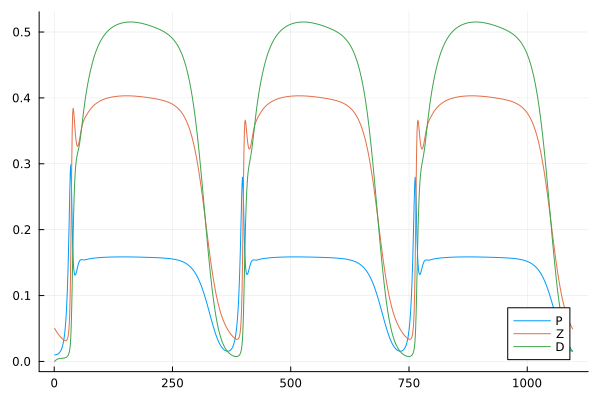

In [6]:
p = plot(timeseries.P, label="P")
plot!(p, timeseries.Z, label="Z")
plot!(p, timeseries.D, label="D")

## OceanBioME

Manually stepping through the sim means we don't have to save anything to a file, otherwise below is doing exactly the same thing as the wrapper above (using the OceanBioME NPZD model).

In [7]:
PAR⁰(t) = 60 * (1 - cos((t + 15days) * 2π / year)) * (1 / (1 + 0.2 * exp(-((mod(t, year) - 200days) / 50days)^2))) + 2

const z = -10 # specify the nominal depth of the box for the PAR profile
PAR_f(t) = PAR⁰(t) * exp(0.2z) # Modify the PAR based on the nominal depth and exponential decay

PAR_f (generic function with 1 method)

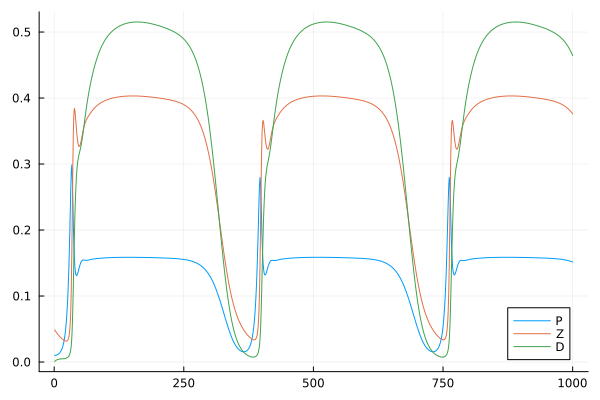

In [8]:
grid = BoxModelGrid()
clock = Clock(time = zero(grid))

PAR = FunctionField{Center, Center, Center}(PAR_f, grid; clock)

biogeochemistry = NutrientPhytoplanktonZooplanktonDetritus(; 
    grid, 
    light_attenuation_model = PrescribedPhotosyntheticallyActiveRadiation(PAR),
    sinking_speeds = NamedTuple()
)
model = BoxModel(;biogeochemistry, clock)

set!(model, N=N, P=P, Z=Z, D=D)

vals_d = []
vals_z = []
vals_p = []
for i in range(1,1000)
    time_step!(model, 1day)
    push!(vals_d, model.fields.D.data[1,1,1])
    push!(vals_z, model.fields.Z.data[1,1,1])
    push!(vals_p, model.fields.P.data[1,1,1])
end

p = plot(vals_p, label="P")
plot!(p, vals_z, label="Z")
plot!(p, vals_d, label="D")

## DifferentialEquations

We can do the same thing without relying on Oceananigans.

In [9]:
include("../examples/NPZD_functions.jl")

zooplankton_assimilation_loss (generic function with 1 method)

In [10]:
function NPZD_DE(du, u, p, t)

    # Model parameters.
    μ₀, kₙ, lᵖⁿ, lᶻⁿ, lᵖᵈ, gₘₐₓ, kₚ, β, lᶻᵈ, rᵈⁿ, α = p 
    # Current state.
    N, P, Z, D = u

    PAR = PAR_f(t)

    # Evaluate differential equations
    du[1]= phytoplankton_metabolic_loss(P, lᵖⁿ) + zooplankton_metabolic_loss(Z, lᶻⁿ) + remineralization(D, rᵈⁿ) - phytoplankton_growth(N, P, PAR, μ₀, kₙ, α)
    du[2] = phytoplankton_growth(N, P, PAR, μ₀, kₙ, α) - phytoplankton_grazing_loss(P, Z, gₘₐₓ, kₚ) - phytoplankton_metabolic_loss(P, lᵖⁿ) - phytoplankton_mortality_loss(P, lᵖᵈ)
    du[3] = zooplankton_grazing_gain(P, Z, β, gₘₐₓ, kₚ) - zooplankton_metabolic_loss(Z, lᶻⁿ) - zooplankton_mortality_loss(Z, lᶻᵈ)
    du[4] = phytoplankton_mortality_loss(P, lᵖᵈ) + zooplankton_assimilation_loss(P, Z, β, gₘₐₓ, kₚ) + zooplankton_mortality_loss(Z, lᶻᵈ) - remineralization(D, rᵈⁿ)

    return nothing
end

NPZD_DE (generic function with 1 method)

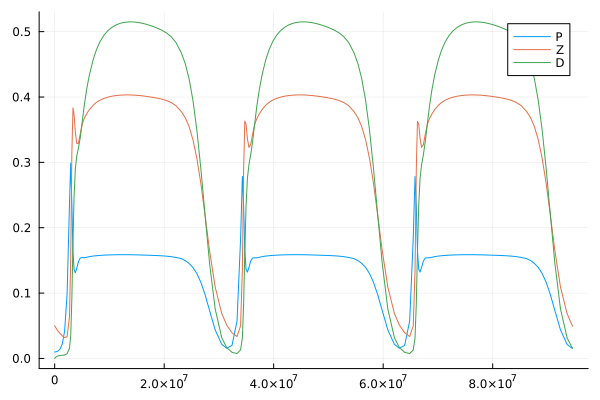

In [11]:
# N,P,Z,D
# collect -> turn tuple to vector
u0 = collect(values(init_conditions)) #[7.0, 0.01, 0.05, 0.0]

p = collect(values(parameters)) #[0.6989, 2.3868, 0.066, 0.0102, 0.0101, 2.1522, 0.5573, 0.9116, 0.3395, 0.1213, 0.1953]

tspan = (0.0,3years)

prob = ODEProblem(NPZD_DE, u0, tspan, p)

# sol = solve(prob, Tsit5(), dt=0.01, adaptive=false)
sol = solve(prob, Tsit5())

# plot(sol)
p = plot(sol.t, [sol.u[i][2] for i in range(1, length(sol))], label="P")
plot!(p, sol.t, [sol.u[i][3] for i in range(1, length(sol))], label="Z")
plot!(p, sol.t, [sol.u[i][4] for i in range(1, length(sol))], label="D")